In [1]:
# ==========================
# RAG Project — Setup Notebook
# Step 0 → Dataset Loading + Chunking
# ==========================

# --------------------------
# 1. Imports & Setup
# --------------------------
import os
import re
from sklearn.datasets import fetch_20newsgroups

# --------------------------
# 2. Define Chunking Functions
# --------------------------
def fixed_chunking(text, chunk_size=300, overlap=50):
    chunks = []
    start = 0
    while start < len(text):
        end = start + chunk_size
        chunks.append(text[start:end])
        start = end - overlap
    return chunks

def sentence_chunking_regex(text, max_words=150):
    """
    Regex-based sentence chunking (no NLTK)
    """
    sentences = re.split(r'(?<=[.!?]) +', text)
    chunks = []
    chunk = ""
    word_count = 0

    for s in sentences:
        w = len(s.split())
        if word_count + w > max_words:
            chunks.append(chunk.strip())
            chunk = s
            word_count = w
        else:
            chunk += " " + s
            word_count += w
    if chunk:
        chunks.append(chunk.strip())
    return chunks

# --------------------------
# 3. Load 20 Newsgroups Dataset
# --------------------------
dataset = fetch_20newsgroups(subset="train", remove=("headers","footers","quotes"))

print(f"Number of documents loaded: {len(dataset.data)}")
print(f"Sample text (first 500 chars) from first doc:\n{dataset.data[0][:500]}")

# --------------------------
# 4. Prepare Output Directories
# --------------------------
os.makedirs("data/chunks/fixed", exist_ok=True)
os.makedirs("data/chunks/sentence", exist_ok=True)

# --------------------------
# 5. Chunk & Save Documents
# --------------------------
for i, text in enumerate(dataset.data[:200]):  # first 200 docs
    # --- Fixed chunking ---
    for j, chunk in enumerate(fixed_chunking(text)):
        with open(f"data/chunks/fixed/doc_{i}chunk{j}.txt", "w", encoding="utf-8") as f:
            f.write(chunk)
    # --- Sentence-based chunking ---
    for j, chunk in enumerate(sentence_chunking_regex(text)):
        with open(f"data/chunks/sentence/doc_{i}chunk{j}.txt", "w", encoding="utf-8") as f:
            f.write(chunk)

print("Chunking complete. Files saved in 'data/chunks/fixed' and 'data/chunks/sentence'")

Number of documents loaded: 11314
Sample text (first 500 chars) from first doc:
I was wondering if anyone out there could enlighten me on this car I saw
the other day. It was a 2-door sports car, looked to be from the late 60s/
early 70s. It was called a Bricklin. The doors were really small. In addition,
the front bumper was separate from the rest of the body. This is 
all I know. If anyone can tellme a model name, engine specs, years
of production, where this car is made, history, or whatever info you
have on this funky looking car, please e-mail.
Chunking complete. Files saved in 'data/chunks/fixed' and 'data/chunks/sentence'


In [2]:
# !pip install sentence-transformers faiss-cpu rank_bm25 transformers
import os
from sentence_transformers import SentenceTransformer
import pickle

# Load all fixed chunks
chunk_dir = "data/chunks/fixed"
chunk_texts = []

for fname in os.listdir(chunk_dir):
    path = os.path.join(chunk_dir, fname)
    with open(path, "r", encoding="utf-8") as f:
        chunk_texts.append(f.read())

print(f"Total fixed chunks: {len(chunk_texts)}")

# Load embedding model
embedder = SentenceTransformer("all-MiniLM-L6-v2")
embeddings = embedder.encode(chunk_texts, show_progress_bar=True, convert_to_numpy=True)

# Save embeddings & chunks for later reuse
with open("data/embeddings.pkl", "wb") as f:
    pickle.dump({"chunks": chunk_texts, "embeddings": embeddings}, f)

print("Embeddings created and saved.")

Total fixed chunks: 1154


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Batches:   0%|          | 0/37 [00:00<?, ?it/s]

Embeddings created and saved.


In [ ]:
import faiss
import numpy as np

# Load embeddings
with open("data/embeddings.pkl", "rb") as f:
    data = pickle.load(f)

chunk_texts = data["chunks"]
embeddings = data["embeddings"]

d = embeddings.shape[1]  # embedding dimension
index = faiss.IndexFlatL2(d)  # L2 distance index
index.add(np.array(embeddings))

print(f"FAISS index created with {index.ntotal} vectors.")

FAISS index created with 1154 vectors.


In [ ]:
from rank_bm25 import BM25Okapi
import re

# Tokenizer function
def simple_tokenize(text):
    # Lowercase + split by non-word characters
    return re.findall(r'\b\w+\b', text.lower())

# Tokenize each chunk for BM25
tokenized_corpus = [simple_tokenize(txt) for txt in chunk_texts]

# Create BM25 index
bm25 = BM25Okapi(tokenized_corpus)

print("✅ BM25 index created")

✅ BM25 index created


In [ ]:
# ==========================
# Step 5: Retrieval Function
# ==========================

import numpy as np

def retrieve(query, top_k=5, use_bm25=False):
    """
    Retrieve top-k relevant chunks for a query.

    Args:
        query (str): User question/query.
        top_k (int): Number of chunks to retrieve.
        use_bm25 (bool): If True, combine FAISS + BM25 retrieval.

    Returns:
        List[str]: Retrieved text chunks.
    """
    # --- 1. Embed query ---
    q_emb = embedder.encode([query], convert_to_numpy=True)

    # --- 2. FAISS retrieval ---
    D, I = index.search(q_emb, top_k)
    faiss_results = [chunk_texts[i] for i in I[0]]

    # --- 3. BM25 retrieval ---
    if use_bm25:
        # Simple regex tokenizer
        import re
        q_tokens = re.findall(r'\b\w+\b', query.lower())
        bm25_scores = bm25.get_scores(q_tokens)
        bm25_top_idx = np.argsort(bm25_scores)[::-1][:top_k]
        bm25_results = [chunk_texts[i] for i in bm25_top_idx]

        # Combine results (union, remove duplicates)
        combined_results = list(dict.fromkeys(faiss_results + bm25_results))
        return combined_results
    else:
        return faiss_results

In [ ]:
query = "What is a Bricklin sports car?"
retrieved_chunks = retrieve(query, top_k=5, use_bm25=True)

print("Top retrieved chunks:\n")
for i, c in enumerate(retrieved_chunks):
    print(f"Chunk {i+1}: {c[:200]}...\n")

Top retrieved chunks:

Chunk 1: I was wondering if anyone out there could enlighten me on this car I saw
the other day. It was a 2-door sports car, looked to be from the late 60s/
early 70s. It was called a Bricklin. The doors were ...

Chunk 2:  
I was thinking about getting a Talon, but I think the insurance is higher
for a "turbo" sports car vs a V6
 
-W
 
======================================================================== 27
 
1986 H...

Chunk 3: parate from the rest of the body. This is 
all I know. If anyone can tellme a model name, engine specs, years
of production, where this car is made, history, or whatever info you
have on this funky lo...

Chunk 4: / hpcc01:rec.motorcycles / Stafford@Vax2.Winona.MSUS.Edu (John Stafford) / 11:06 am  Apr  1, 1993 /
 

  It depreciates much faster, too.
   
John ...

Chunk 5: elt and 5+mph bumpers.
I figure that 30mph collisions into brick walls aren't common enough
for me to spend that much extra money for protection, but there are
lots 

In [ ]:
from transformers import pipeline

# Load a lightweight LLM for text generation
generator = pipeline(
    "text-generation",
    model="EleutherAI/gpt-neo-125M",
    device=-1  # CPU; change to 0 if you have a GPU
)

def generate_answer(query, top_k=5, use_bm25=False):
    """
    Retrieve relevant chunks and generate answer using LLM.
    """
    # Retrieve chunks
    retrieved_chunks = retrieve(query, top_k=top_k, use_bm25=use_bm25)

    # Combine retrieved chunks into context
    context = "\n".join(retrieved_chunks)

    # Prepare prompt
    prompt = f"""Answer the following question using ONLY the information below.
If the answer is not present, say 'Unknown'.

Context:
{context}

Question: {query}
Answer:"""

    # Generate answer
    output = generator(prompt, max_length=300, do_sample=False)[0]['generated_text']

    # Strip repeated prompt text
    answer = output.split("Answer:")[-1].strip()
    return answer

config.json: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/526M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/119 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/727 [00:00<?, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/357 [00:00<?, ?B/s]

Device set to use cpu


In [ ]:
query = "What is a Bricklin sports car?"
answer = generate_answer(query, top_k=5, use_bm25=True)

print(f"Query: {query}\nAnswer: {answer}")

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Both `max_new_tokens` (=256) and `max_length`(=300) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Query: What is a Bricklin sports car?
Answer: ======================================================================== 28
 
1987 Honda CRX Si, clean record, in a small New Mexico town was around $800
per year, age 24.
 
Nearby cit
parate from the rest of the body. This is 
all I know. If anyone can tellme a model name, engine specs, years
of production, where this car is made, history, or whatever info you
have on this funky looking car, please e-mail.
/ hpcc01:rec.motorcycles / Stafford@Vax2.Winona.MSUS.Edu (John Stafford) / 11:06 am  Apr  1, 1993 /
 

  It depreciates much faster, too.
 
======================================================================== 29
 
1988 Honda CRX Si, clean record, in a small New Mexico town was around $800
per year, age 24.
 
Nearby cit
parate from the rest of the body. This is 
all I know. If anyone can tellme a model name, engine specs, years
of production, where this car is made, history, or whatever info you
have on this funky looking car, please 

In [ ]:
import pandas as pd
import numpy as np
import re

# 1. Define helper function to compute simple precision/recall
def compute_overlap(pred, truth):
    """
    Compute simple overlap-based precision & recall between predicted and ground truth.
    """
    pred_tokens = set(re.findall(r'\b\w+\b', pred.lower()))
    truth_tokens = set(re.findall(r'\b\w+\b', truth.lower()))

    if len(pred_tokens) == 0:
        precision = 0.0
    else:
        precision = len(pred_tokens & truth_tokens) / len(pred_tokens)

    if len(truth_tokens) == 0:
        recall = 0.0
    else:
        recall = len(pred_tokens & truth_tokens) / len(truth_tokens)

    return precision, recall

# 2. Define example queries that exist in 20 Newsgroups
# This list can be expanded for research evaluation
evaluation_queries = [
    {
        "query": "What is a Space shuttle?",
        "answer": "A spacecraft used by NASA for transporting astronauts and cargo into space."
    },
    {
        "query": "Explain the computer graphics system",
        "answer": "A system that enables the creation and manipulation of visual images on a computer."
    },
    {
        "query": "Describe the religious topic of Christianity",
        "answer": "Christianity is a religion based on the life and teachings of Jesus Christ."
    }
]

# 3. Evaluate each query using RAG
results = []

for q in evaluation_queries:
    pred = generate_answer(q["query"], top_k=5, use_bm25=True)

    # Compute precision & recall
    precision, recall = compute_overlap(pred, q["answer"])

    # Check hallucination (if answer contains words not in retrieved chunks)
    retrieved_chunks = retrieve(q["query"], top_k=5, use_bm25=True)
    context_tokens = set(" ".join(retrieved_chunks).lower().split())
    pred_tokens = set(pred.lower().split())
    hallucination_rate = 1 - (len(pred_tokens & context_tokens) / max(1, len(pred_tokens)))

    results.append({
        "query": q["query"],
        "ground_truth": q["answer"],
        "predicted": pred,
        "precision": precision,
        "recall": recall,
        "hallucination_rate": hallucination_rate,
        "answer_length": len(pred.split())
    })

# 4. Save results in pandas DataFrame
df_results = pd.DataFrame(results)
print(df_results)

# Save CSV for paper tables
df_results.to_csv("data/rag_evaluation_results.csv", index=False)
print("✅ Evaluation results saved to 'data/rag_evaluation_results.csv'")

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Both `max_new_tokens` (=256) and `max_length`(=300) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Both `max_new_tokens` (=256) and `max_length`(=300) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Both `max_new_tokens` (=256) and `max_length`(=300) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


                                          query  \
0                      What is a Space shuttle?   
1          Explain the computer graphics system   
2  Describe the religious topic of Christianity   

                                        ground_truth  \
0  A spacecraft used by NASA for transporting ast...   
1  A system that enables the creation and manipul...   
2  Christianity is a religion based on the life a...   

                                           predicted  precision    recall  \
0  .\n\n    The following is a summary of the inf...   0.166667  0.416667   
1  * Computer Vision and Object Recognition\n    ...   0.120000  0.461538   
2  leaders to kill their own\nbelievers.  The poi...   0.071429  0.461538   

   hallucination_rate  answer_length  
0            0.424242            162  
1            0.000000             73  
2            0.011905            203  
✅ Evaluation results saved to 'data/rag_evaluation_results.csv'


In [ ]:
import pandas as pd
import numpy as np
import re

# Simple function to compute precision & recall
def compute_overlap(pred, truth):
    pred_tokens = set(re.findall(r'\b\w+\b', pred.lower()))
    truth_tokens = set(re.findall(r'\b\w+\b', truth.lower()))
    precision = len(pred_tokens & truth_tokens) / max(1, len(pred_tokens))
    recall = len(pred_tokens & truth_tokens) / max(1, len(truth_tokens))
    return precision, recall

# Define evaluation queries (expand as needed)
evaluation_queries = [
    {
        "query": "What is a Space shuttle?",
        "answer": "A spacecraft used by NASA for transporting astronauts and cargo into space."
    },
    {
        "query": "Explain the computer graphics system",
        "answer": "A system that enables the creation and manipulation of visual images on a computer."
    },
    {
        "query": "Describe the religious topic of Christianity",
        "answer": "Christianity is a religion based on the life and teachings of Jesus Christ."
    }
]

# Define experiment variations
experiments = [
    {"name": "FAISS + Fixed chunks", "top_k": 5, "use_bm25": False, "chunk_type": "fixed"},
    {"name": "FAISS + Sentence chunks", "top_k": 5, "use_bm25": False, "chunk_type": "sentence"},
    {"name": "Hybrid + Fixed chunks", "top_k": 5, "use_bm25": True, "chunk_type": "fixed"},
    {"name": "Hybrid + Sentence chunks", "top_k": 5, "use_bm25": True, "chunk_type": "sentence"},
]

# Function to switch chunks dynamically
def switch_chunk_type(chunk_type):
    global chunk_texts, index, bm25
    if chunk_type == "fixed":
        chunk_dir = "data/chunks/fixed"
    else:
        chunk_dir = "data/chunks/sentence"

    # Load chunks
    chunk_texts = []
    for fname in os.listdir(chunk_dir):
        path = os.path.join(chunk_dir, fname)
        with open(path, "r", encoding="utf-8") as f:
            chunk_texts.append(f.read())

    # Recompute FAISS embeddings
    embeddings = embedder.encode(chunk_texts, show_progress_bar=False, convert_to_numpy=True)
    d = embeddings.shape[1]
    index = faiss.IndexFlatL2(d)
    index.add(np.array(embeddings))

    # Rebuild BM25
    tokenized_corpus = [re.findall(r'\b\w+\b', txt.lower()) for txt in chunk_texts]
    bm25 = BM25Okapi(tokenized_corpus)

# Store results
all_results = []

# Run experiments
for exp in experiments:
    print(f"Running experiment: {exp['name']}")
    switch_chunk_type(exp['chunk_type'])

    for q in evaluation_queries:
        pred = generate_answer(q['query'], top_k=exp['top_k'], use_bm25=exp['use_bm25'])
        precision, recall = compute_overlap(pred, q['answer'])

        # Hallucination: fraction of tokens not in retrieved chunks
        retrieved_chunks = retrieve(q['query'], top_k=exp['top_k'], use_bm25=exp['use_bm25'])
        context_tokens = set(" ".join(retrieved_chunks).lower().split())
        pred_tokens = set(pred.lower().split())
        hallucination_rate = 1 - (len(pred_tokens & context_tokens) / max(1, len(pred_tokens)))

        all_results.append({
            "experiment": exp['name'],
            "query": q['query'],
            "ground_truth": q['answer'],
            "predicted": pred,
            "precision": precision,
            "recall": recall,
            "hallucination_rate": hallucination_rate,
            "answer_length": len(pred.split())
        })

# Convert to DataFrame
df_experiments = pd.DataFrame(all_results)
print(df_experiments)

# Save CSV for paper tables
df_experiments.to_csv("data/rag_experiment_results.csv", index=False)
print("✅ Experiment results saved to 'data/rag_experiment_results.csv'")

Running experiment: FAISS + Fixed chunks


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Both `max_new_tokens` (=256) and `max_length`(=300) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Both `max_new_tokens` (=256) and `max_length`(=300) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Both `max_new_tokens` (=256) and `max_length`(=300) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Running experiment: FAISS + Sentence chunks


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Both `max_new_tokens` (=256) and `max_length`(=300) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Both `max_new_tokens` (=256) and `max_length`(=300) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Both `max_new_tokens` (=256) and `max_length`(=300) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Running experiment: Hybrid + Fixed chunks


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Both `max_new_tokens` (=256) and `max_length`(=300) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Both `max_new_tokens` (=256) and `max_length`(=300) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Both `max_new_tokens` (=256) and `max_length`(=300) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Running experiment: Hybrid + Sentence chunks


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Both `max_new_tokens` (=256) and `max_length`(=300) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Both `max_new_tokens` (=256) and `max_length`(=300) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Both `max_new_tokens` (=256) and `max_length`(=300) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


                  experiment                                         query  \
0       FAISS + Fixed chunks                      What is a Space shuttle?   
1       FAISS + Fixed chunks          Explain the computer graphics system   
2       FAISS + Fixed chunks  Describe the religious topic of Christianity   
3    FAISS + Sentence chunks                      What is a Space shuttle?   
4    FAISS + Sentence chunks          Explain the computer graphics system   
5    FAISS + Sentence chunks  Describe the religious topic of Christianity   
6      Hybrid + Fixed chunks                      What is a Space shuttle?   
7      Hybrid + Fixed chunks          Explain the computer graphics system   
8      Hybrid + Fixed chunks  Describe the religious topic of Christianity   
9   Hybrid + Sentence chunks                      What is a Space shuttle?   
10  Hybrid + Sentence chunks          Explain the computer graphics system   
11  Hybrid + Sentence chunks  Describe the religious topic of Ch

                experiment                                         query  \
0     FAISS + Fixed chunks                      What is a Space shuttle?   
1     FAISS + Fixed chunks          Explain the computer graphics system   
2     FAISS + Fixed chunks  Describe the religious topic of Christianity   
3  FAISS + Sentence chunks                      What is a Space shuttle?   
4  FAISS + Sentence chunks          Explain the computer graphics system   

                                        ground_truth  \
0  A spacecraft used by NASA for transporting ast...   
1  A system that enables the creation and manipul...   
2  Christianity is a religion based on the life a...   
3  A spacecraft used by NASA for transporting ast...   
4  A system that enables the creation and manipul...   

                                           predicted  precision    recall  \
0  .\n\n    The following is a summary of the inf...   0.166667  0.416667   
1  * Computer Vision and Object Recognition\n    ...

/tmp/ipython-input-491417397.py:35: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(x="experiment", y=metric, data=df, ci=None)


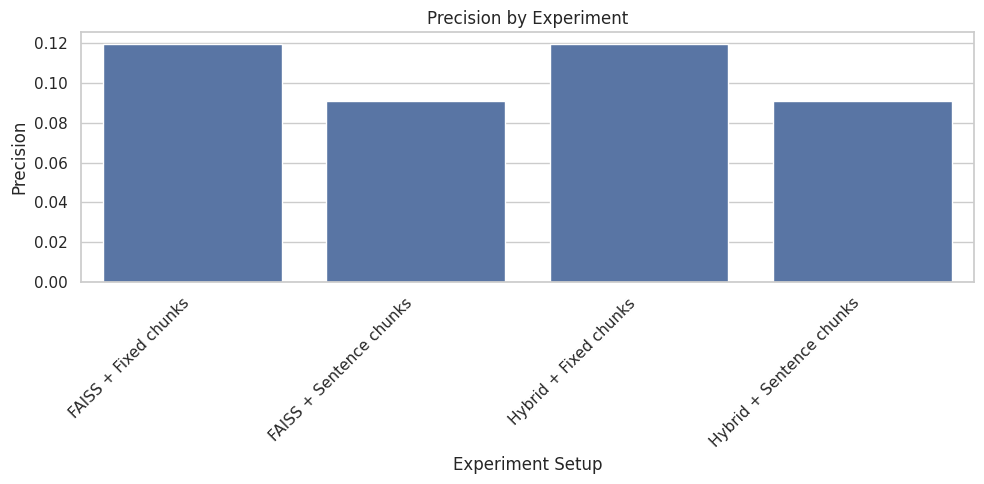

/tmp/ipython-input-491417397.py:35: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(x="experiment", y=metric, data=df, ci=None)


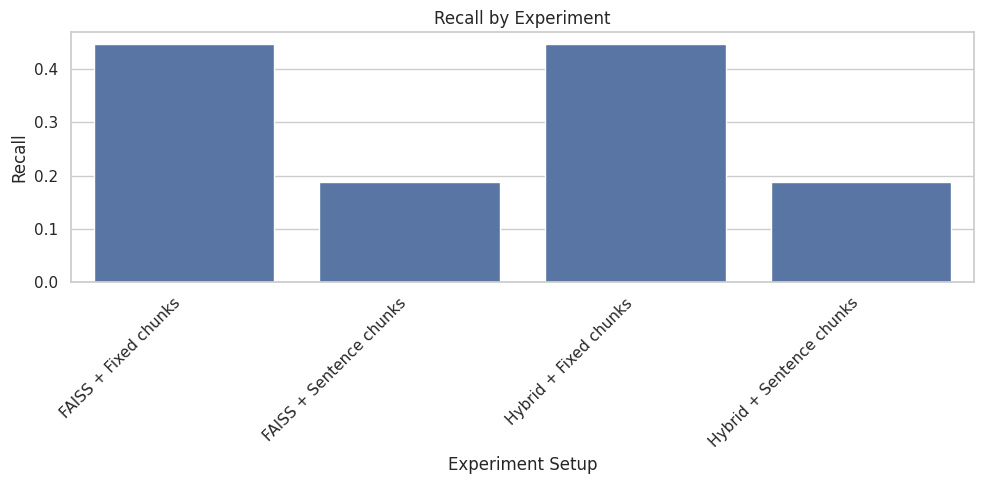

/tmp/ipython-input-491417397.py:35: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(x="experiment", y=metric, data=df, ci=None)


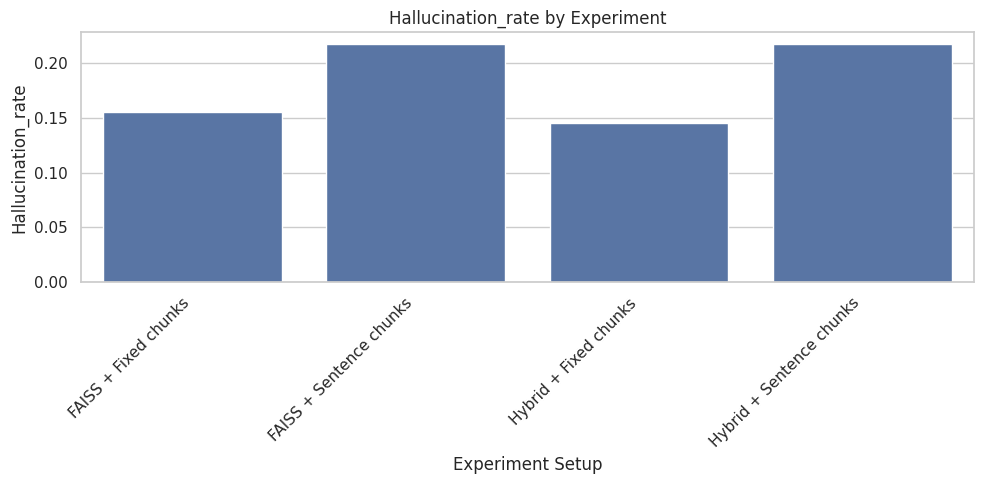

/tmp/ipython-input-491417397.py:35: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(x="experiment", y=metric, data=df, ci=None)


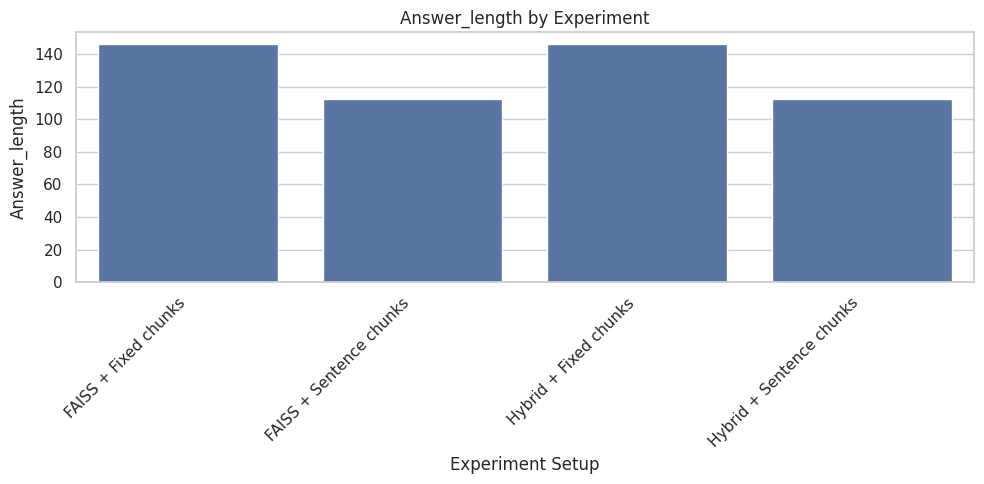

/tmp/ipython-input-491417397.py:51: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(x='retrieval', y=metric, hue='chunking', data=df, ci=None)


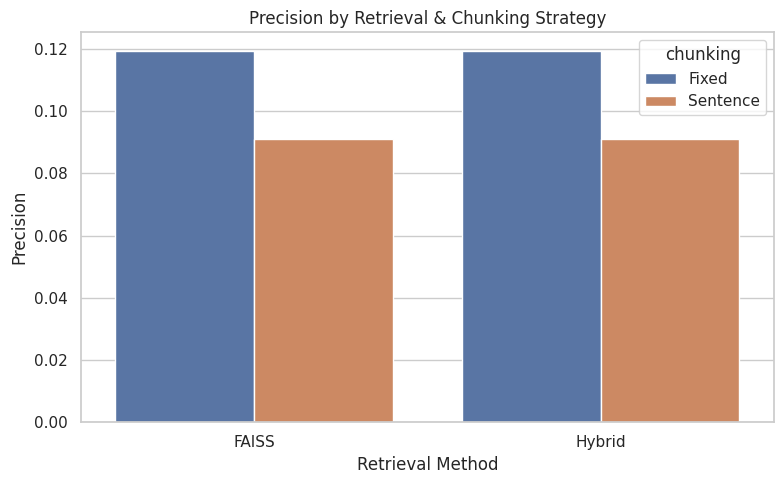

/tmp/ipython-input-491417397.py:51: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(x='retrieval', y=metric, hue='chunking', data=df, ci=None)


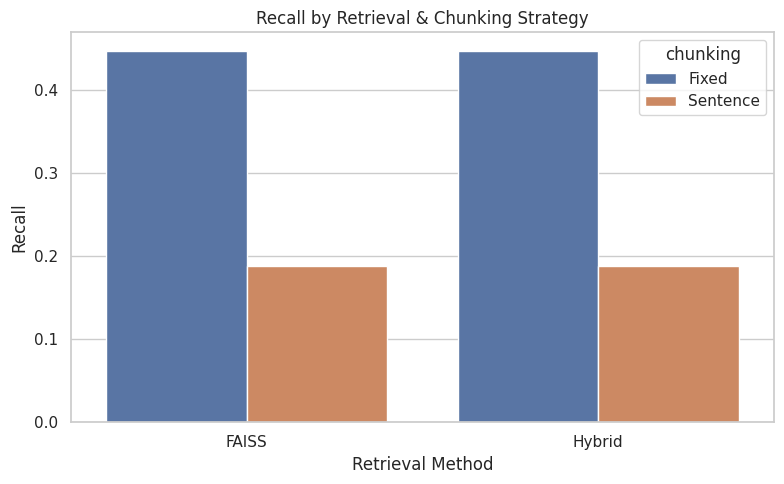

/tmp/ipython-input-491417397.py:51: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(x='retrieval', y=metric, hue='chunking', data=df, ci=None)


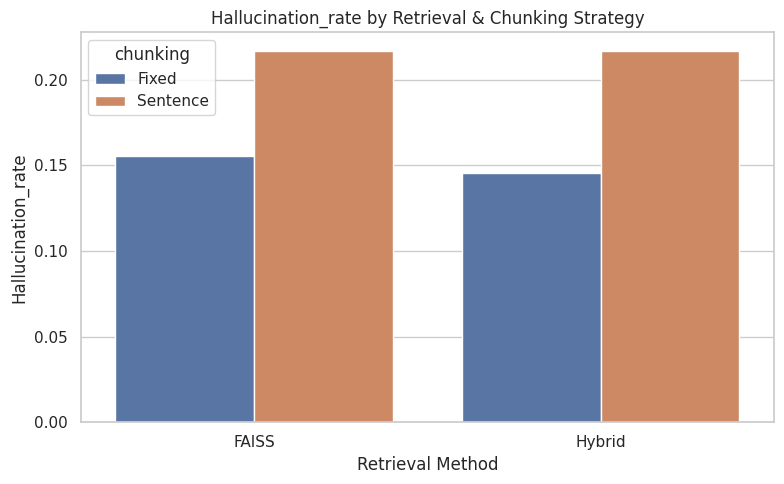

/tmp/ipython-input-491417397.py:51: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(x='retrieval', y=metric, hue='chunking', data=df, ci=None)


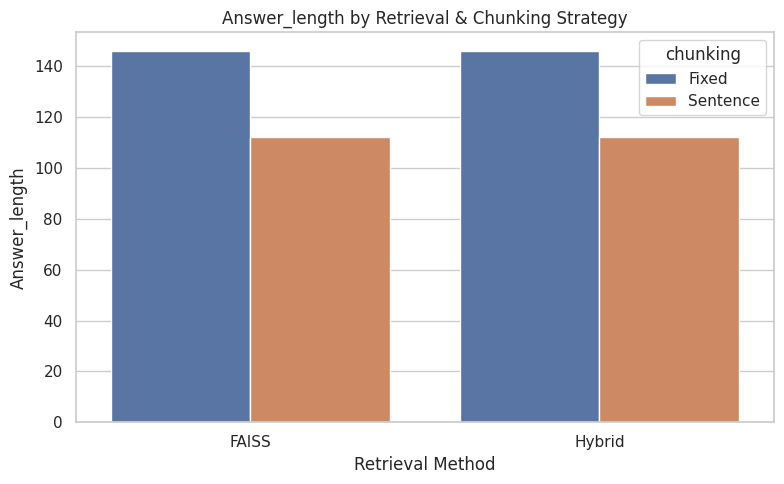

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# -----------------------------
# 1. Load experiment results
# -----------------------------
df = pd.read_csv("data/rag_experiment_results.csv")
print(df.head())

# -----------------------------
# 2. Create summary table by experiment
# -----------------------------
summary = df.groupby("experiment").agg({
    "precision": "mean",
    "recall": "mean",
    "hallucination_rate": "mean",
    "answer_length": "mean"
}).reset_index()

print("✅ Summary table by experiment:")
print(summary)

# Optional: save summary table for paper
summary.to_csv("data/rag_summary_table.csv", index=False)

# -----------------------------
# 3. Bar plots
# -----------------------------
sns.set(style="whitegrid")
metrics = ["precision", "recall", "hallucination_rate", "answer_length"]

for metric in metrics:
    plt.figure(figsize=(10,5))
    sns.barplot(x="experiment", y=metric, data=df, ci=None)
    plt.xticks(rotation=45, ha="right")
    plt.title(f"{metric.capitalize()} by Experiment")
    plt.ylabel(metric.capitalize())
    plt.xlabel("Experiment Setup")
    plt.tight_layout()
    plt.show()

# -----------------------------
# 4. FAISS vs Hybrid comparison
# -----------------------------
df['retrieval'] = df['experiment'].apply(lambda x: 'Hybrid' if 'Hybrid' in x else 'FAISS')
df['chunking'] = df['experiment'].apply(lambda x: 'Sentence' if 'Sentence' in x else 'Fixed')

for metric in metrics:
    plt.figure(figsize=(8,5))
    sns.barplot(x='retrieval', y=metric, hue='chunking', data=df, ci=None)
    plt.title(f"{metric.capitalize()} by Retrieval & Chunking Strategy")
    plt.ylabel(metric.capitalize())
    plt.xlabel("Retrieval Method")
    plt.tight_layout()
    plt.show()